In [6]:
# Realized σ vs EWMA σ: realized uses a fixed window and treats each day equally; 
#EWMA down-weights older shocks, adapting faster to regime shifts.

# Finite-window EWMA: a “local” view—weights normalized within the last n days 
#only; useful for near-term forecasts (rolling forward section).


#VaR/ES:
#Historical: model-free, uses your own tail—good when distributions are non-Normal.
#Normal-EWMA: tractable & responsive via λ, but can understate fat tails.
#ES complements VaR by averaging the size of tail losses, not just the cutoff.


#Backtests:
#Kupiec checks if the rate of breaches matches the target (e.g., ~5% for 95%).
#Christoffersen checks for clustering (independence); a good model shouldn’t produce streaky exceptions.

In [1]:
# --- Make local package importable (robust for notebooks in subfolders) ---
import sys
from pathlib import Path

def add_src_to_path(pkg="quantlib", levels_up=3):
    here = Path.cwd().resolve()
    candidates = [here / "src"]
    # also check parents: ../src, ../../src, ...
    for i in range(1, levels_up+1):
        candidates.append(here.parents[i-1] / "src")
    for p in candidates:
        if (p / pkg / "__init__.py").exists():
            sys.path.insert(0, str(p))
            print(f"[OK] Added to sys.path: {p}")
            return p
    raise FileNotFoundError("Could not find src/quantlib/__init__.py relative to this notebook.")

add_src_to_path()


[OK] Added to sys.path: C:\Users\quantbase\Desktop\quant\src


WindowsPath('C:/Users/quantbase/Desktop/quant/src')

In [2]:
# --- bootstrap & imports ---
import sys, pathlib; sys.path.append(str(pathlib.Path.cwd() / "src"))
from pathlib import Path
import pandas as pd
import numpy as np
from quantlib import risk as qrisk
import importlib, quantlib.viz as qviz
DATA_INT = Path(r"C:\Users\quantbase\Desktop\quant\data_int")
FIG_DIR = Path(r"C:\Users\quantbase\Desktop\quant\figures"); FIG_DIR.mkdir(exist_ok=True, parents=True)


qrisk = importlib.reload(qrisk)
qviz = importlib.reload(qviz)


In [3]:
# --- load portfolio returns ---
r_port = pd.read_pickle(DATA_INT/"portfolio_returns.pkl").sort_index()

In [4]:
# --- Historical VaR/ES (252d, 95%) & Normal-EWMA VaR/ES (λ=0.94) ---
hist_252_95 = qrisk.hist_var_es(r_port, window=252, alpha=0.95)
norm_ewma_95 = qrisk.normal_ewma_var_es(r_port, lam=0.94, alpha=0.95)


In [5]:
# --- Backtest exceptions + p-values (Kupiec & Christoffersen) ---
exc = qrisk.var_exceptions(r_port, hist_252_95["VaR"])
p_uc, s_uc   = qrisk.kupiec_pvalue(exc, alpha=0.95)
p_ind, s_ind = qrisk.christoffersen_pvalue(exc)
traffic = qrisk.traffic_light(p_uc, p_ind)

In [6]:
print("Kupiec:", s_uc, "p=", p_uc)
print("Christoffersen:", s_ind, "p=", p_ind)
print("Traffic:", traffic)


Kupiec: {'T': 856, 'N': 37, 'LR_uc': 0.8653753855648899, 'phat': 0.04322429906542056, 'p': 0.050000000000000044} p= 0.3522387871288163
Christoffersen: {'LR_ind': 2.8668853672421317, 'N00': 785, 'N01': 33, 'N10': 33, 'N11': 4, 'pi0': 0.040342298288508556, 'pi1': 0.10810810810810811, 'pi': 0.04327485380116959} p= 0.09041970126589649
Traffic: GREEN


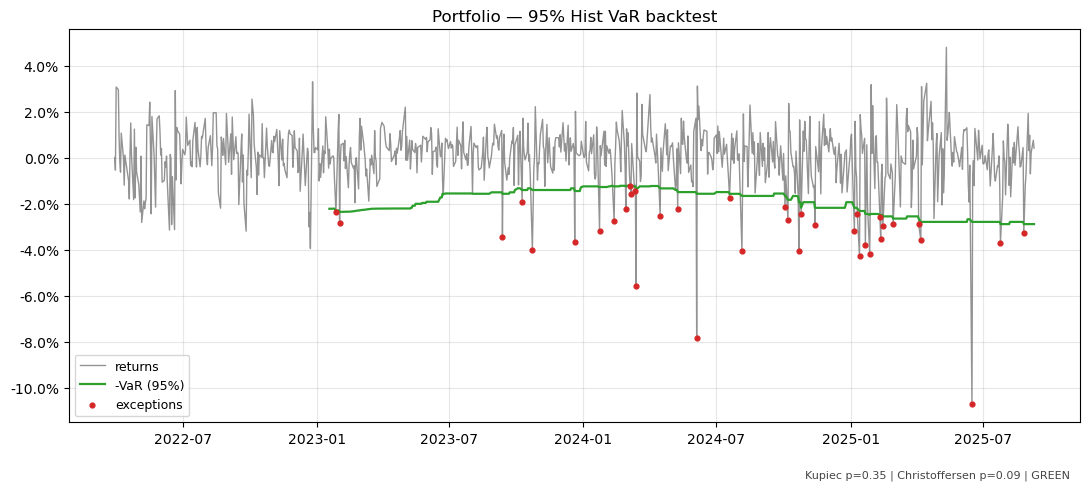

In [7]:
# --- Visual backtest ---
foot = f"Kupiec p={p_uc:.2f} | Christoffersen p={p_ind:.2f} | {traffic}"
qviz.plot_var_exceptions(r_port, hist_252_95['VaR'], title="Portfolio — 95% Hist VaR backtest", alpha_label="95%", footnote=foot, save_path=FIG_DIR/"var_hist_95.png")


In [8]:
#hist_63_95 = qrisk.hist_var_es(r_p, window=63, alpha=0.95)


In [9]:
hist_21_95 = qrisk.hist_var_es(r_port, window=21, alpha=0.95)


In [10]:
#(hist_63_95)

In [11]:
hist_21_95

,VaR,ES
date,,
2022-03-30,NaN,NaN
2022-03-31,NaN,NaN
2022-04-01,NaN,NaN
2022-04-04,NaN,NaN
2022-04-05,NaN,NaN
...,...,...
2025-09-03,0.017074,0.024892
2025-09-04,0.017074,0.024892
2025-09-05,0.017074,0.024892


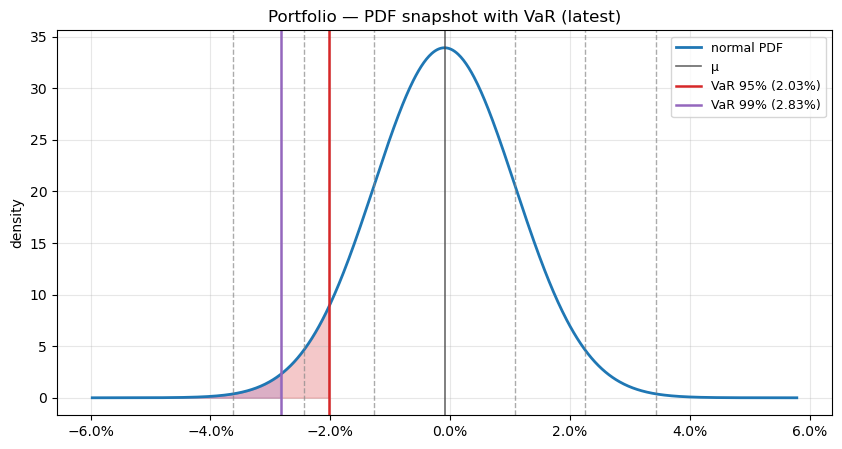

In [12]:
# Load portfolio returns (or pick a symbol)
r_port = pd.read_pickle(DATA_INT/"portfolio_returns.pkl").sort_index()

# Choose estimator for today's σ (examples)
sigma_today = qrisk.ewma_var_recursive(r_port, lam=0.94).pow(0.5).iloc[-1]     # EWMA(0.94)
# or: sigma_today = qrisk.realized_vol(r_port, 252).iloc[-1]                   # 1Y realized

# drift (use 0 or small rolling mean)
mu_today = r_port.rolling(252).mean().iloc[-1]
if not np.isfinite(mu_today): mu_today = 0.0

# Plot snapshot PDF with 95% & 99% VaR shading + ±1/2/3σ lines
qviz.plot_var_pdf_snapshot(
    mu=float(mu_today),
    sigma=float(sigma_today),
    alphas=(0.95, 0.99),
    dist="normal",
    title="Portfolio — PDF snapshot with VaR (latest)",
    save_path=FIG_DIR/"var_snapshot_normal.png"
)
